In [1]:
import os
import cv2
import scipy
import torch
import pickle
import matplotlib
import numpy as np
import torchvision
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from scipy import ndimage
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from skimage.transform import resize
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score,accuracy_score

# IMPORTANT NOTICE
You do not need to run this notebook. It is outdated and is only meant for comparison purposes.

There might be some inconsistencies, as this notebook has not been properly versioned.

## CUDA
We heavily recommend CUDA. If you don't have it, clone the repository to a server and run it there

In [2]:
use_cuda = torch.cuda.is_available()

## Headers
Change these cells below to change the parameters of the model.
It is recommended to keep the file hierarchy in the GitHub repository.

In [3]:
IMG_WINDOW_SIZE = (64,64)
LAB_WINDOW_SIZE = (1,1)
NO_EPOCH = 100
BATCH_SIZE = 16
PREDICT_BATCH_SIZE = 608
LOAD_MODEL = True

SAMPLES_PER_IMG = 1000
SEED = 69
POISSON_R2 = 5

## Model and Function Definitions

In [4]:
class MyDataLoader():
    def __init__(self, train_path, label_path, test_path, ):
        self.train_path = train_path
        self.test_path = test_path
        self.label_path = label_path
        
        self.train_img = None
        self.train_lab = None
        self.train_iws = None
        self.train_lws = None
        
        self.train_ptc = None
        self.train_lbl = None
        
        self.train_ptc_s = None
        self.train_lbl_s = None
        
        self.valid_ptc_s = None
        self.valid_lbl_s = None
        
    def load_train(self, no_images, img_window_size=(63,63), label_window_size=(1,1)):
        data_dir = os.listdir(self.train_path)
        label_dir = os.listdir(self.label_path)
        data_list = []
        label_list = []
        for i in range(min(no_images, len(data_dir))):
            img = np.array(Image.open(self.train_path + '/' + data_dir[i])).astype('float32') / 255
            lab = np.array(Image.open(self.label_path + '/' + label_dir[i])).astype('float32') / 255
            
            img_padr = img_window_size[0] // 2
            img_padc = img_window_size[1] // 2
            
            lab_padr = label_window_size[0] // 2
            lab_padc = label_window_size[1] // 2
            
            img_padded = np.pad(img,((img_padr,img_padr), (img_padc,img_padc), (0, 0)),mode='reflect')
            lab_padded = np.pad(lab,((lab_padr,lab_padr), (lab_padc,lab_padc)),mode='reflect')
            
            data_list.append(img_padded)
            label_list.append(lab_padded)
        
        data_list = np.array(data_list)
        label_list = np.array(label_list)
        self.train_img = data_list
        self.train_lab = label_list
        self.train_iws = img_window_size
        self.train_lws = label_window_size
        
    def sample_from_set(self, samples_per_img=100,seed=69, poisson_r2=None):
        
        #if self.train_iws is None or self.train_lws is None or self.train_img is None or self.train_lab:
        #    raise Exception('DataLoader does not have any images loaded...')
        train_ptc_nc, train_lbl_nc = Utils.sample_imgs(self.train_img, self.train_lab, samples_per_img, self.train_iws, self.train_lws, poisson_r2, seed)
        self.train_ptc, self.train_lbl = np.concatenate(train_ptc_nc, axis = 0), np.concatenate(train_lbl_nc, axis = 0)
    
    def shuffle(self,seed=69):
        #if self.train_iws is None or self.train_lws is None or self.train_img is None or self.train_lab:
        #    raise Exception('DataLoader does not have any images loaded...')
        perm = np.random.permutation(self.train_ptc.shape[0])
        self.train_ptc = self.train_ptc[perm]
        self.train_lbl = self.train_lbl[perm]
        
    def augment(self,rotations=[0,90,180,270]):
        augmented_imgs = []
        augmented_labs = []
        for i in range(self.train_ptc.shape[0]):
            for t in rotations:
                augmented_imgs.append(scipy.ndimage.rotate(self.train_ptc[i],t,reshape=False))
                augmented_labs.append(scipy.ndimage.rotate(self.train_lbl[i],t,reshape=False))
        self.train_ptc = np.array(augmented_imgs)
        self.train_lbl = np.array(augmented_labs)
        
    def split_data(self,train_split_ratio):
        #if self.train_iws is None or self.train_lws is None or self.train_img is isNone or self.train_lab:
        #    raise Exception('DataLoader does not have any images loaded...')
        #elif self.train_ptc is None or self.train_lbl is None:
        #    raise Exception('DataLoader does not have samples from images...')
            
        split_idx = np.floor(self.train_ptc.shape[0] * train_split_ratio).astype(np.int32)
        self.valid_ptc_s, self.valid_lbl_s = self.train_ptc[split_idx:], self.train_lbl[split_idx:]
        self.train_ptc_s, self.train_lbl_s = self.train_ptc[:split_idx], self.train_lbl[:split_idx]
        
    def get_notpadded(self):
        
        img_padr = self.train_iws[0] // 2
        img_padc = self.train_iws[1] // 2
            
        lab_padr = self.train_lws[0] // 2
        lab_padc = self.train_lws[1] // 2
        
        train_image_shape = self.train_img.shape
        train_label_shape = self.train_lab.shape
        return self.train_img[:,img_padr:train_image_shape[1]-img_padr, img_padc:train_image_shape[2]-img_padc,:],\
            self.train_lab[:,lab_padr:train_label_shape[1]-lab_padr, lab_padc:train_label_shape[2]-lab_padc] 
    
    def get(self):
        return self.train_ptc_s, self.train_lbl_s, self.valid_ptc_s, self.valid_lbl_s

In [5]:
 class Utils():
    def sample_img(img,lab,samples_per_img=100,img_window_size=(63,63),label_window_size=(15,15),poisson_r2=None,seed=69):
        img_padr = img_window_size[0] // 2
        img_padc = img_window_size[1] // 2

        lab_padr = label_window_size[0] // 2
        lab_padc = label_window_size[1] // 2
        
        if poisson_r2 is None:
            poisson_r2 = np.sqrt(((img_padr // 2) ** 2 + (img_padc // 2) ** 2) / 2)
        
        np.random.seed(seed)
        r_idx = np.random.randint(0, img.shape[0]-img_window_size[0])
        c_idx = np.random.randint(0, img.shape[1]-img_window_size[1])
        samples = [(r_idx,c_idx)]
        for i in range(samples_per_img-1):
            near = True
            while near:
                near = False
                r_idx = np.random.randint(0, img.shape[0]-img_window_size[0])
                c_idx = np.random.randint(0, img.shape[1]-img_window_size[1])
                for sample in samples:
                    if (r_idx - sample[0]) ** 2 + (c_idx - sample[1]) ** 2 < poisson_r2:
                        near = True
                        break
            samples.append((r_idx,c_idx))
        
        sample_img_list = []
        sample_lab_list = []
        for sample in samples:
            odd_r = 1 if img_window_size[0] % 2 == 1 else 0
            odd_c = 1 if img_window_size[1] % 2 == 1 else 0
            sample_img_list.append(img[sample[0]:sample[0]+img_window_size[0],sample[1]:sample[1]+img_window_size[1],:])
            sample_lab_list.append(lab[sample[0]:sample[0]+label_window_size[0],sample[1]:sample[1]+label_window_size[1]])
        return np.array(sample_img_list), np.array(sample_lab_list)
    
    def sample_imgs(imgs,labs,samples_per_img=100,img_window_size=(63,63),label_window_size=(15,15),poisson_r2=None,seed=69):
        samples = []
        labels = []
        for i in range(imgs.shape[0]):
            s,l = Utils.sample_img(imgs[i], labs[i], samples_per_img, img_window_size, label_window_size, poisson_r2, seed)
            samples.append(s)
            labels.append(l)
        return np.array(samples), np.array(labels)
        
    
    def batch(train,label,batch_size=64):
        for i in range(len(train) // batch_size):
            yield train[i*batch_size:(i+1)*batch_size], label[i*batch_size:(i+1)*batch_size]

In [6]:
loader = MyDataLoader('training/images', 'training/groundtruth', '.')
loader.load_train(no_images=100,img_window_size=IMG_WINDOW_SIZE,label_window_size=LAB_WINDOW_SIZE)
loader.sample_from_set(samples_per_img=SAMPLES_PER_IMG, seed=SEED, poisson_r2=POISSON_R2)
#loader.augment()
loader.shuffle()
loader.split_data(train_split_ratio=0.8)
train_img, train_lab, valid_img, valid_lab = loader.get()
train_lab = (train_lab>0.5).flatten()
valid_lab = (valid_lab>0.5).flatten()
valid_img_t = torch.from_numpy(np.transpose(valid_img,(0,3,1,2))).float().cuda()

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv = nn.Sequential(nn.Conv2d(3,64,kernel_size=4)
                               ,nn.LeakyReLU(0.1)
                               ,nn.MaxPool2d(2)
                               ,nn.Dropout(0.25)
                               ,nn.Conv2d(64,128,kernel_size=3)
                               ,nn.LeakyReLU(0.1)
                               ,nn.MaxPool2d(2)
                               ,nn.Dropout(0.25)
                               ,nn.Conv2d(128,256,kernel_size=3)
                               ,nn.LeakyReLU(0.1)
                               ,nn.MaxPool2d(2)
                               ,nn.Dropout(0.25)
                               ,nn.Conv2d(256,256,kernel_size=3)
                               ,nn.LeakyReLU(0.1)
                               ,nn.MaxPool2d(2)
                               ,nn.Dropout(0.25))
        
        self.linear = nn.Sequential(nn.Linear(1024, 128)
                                   ,nn.LeakyReLU(0.1)
                                   ,nn.Dropout(0.5)
                                   ,nn.Linear(128, 2))
        
    def forward(self,x):
        x = self.conv(x)
        x = torch.flatten(x,start_dim = 1,end_dim=-1)
        x = self.linear(x)
        x = x.view(-1,2)
        return x

In [7]:
model = Net()
if LOAD_MODEL:
    model.load_state_dict(torch.load('model_basic_conv_1')['model_state_dict'])
if use_cuda:
    model.cuda()

## Training

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

In [20]:
def train_model(model, train_img, train_lab, valid_img, valid_lab, NO_EPOCH, BATCH_SIZE, optimizer, criterion, verbose = True):
    for epoch in range(NO_EPOCH):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        i = 0
        batch_no=0
        loss_train = 0
        for im, lb, in Utils.batch(train_img, train_lab, BATCH_SIZE):
            # get the inputs; data is a list of [inputs, labels]
            if use_cuda:
                sample = torch.from_numpy(np.transpose(im,(0,3,1,2))).float().cuda()
                truth = torch.from_numpy(lb).long().cuda()
            else:
                sample = torch.from_numpy(np.transpose(im,(0,3,1,2)))
                truth = torch.from_numpy(lb).view(-1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            out = model(sample)
            loss = criterion(out, truth)
            loss.backward()
            optimizer.step()
            # print statistics
            if verbose:
                
                i += 1
                batch_no +=1
                loss_train += loss.item()
                running_loss += loss.item()
                if i % 500 == 0:    # print every 25 mini-batches
                    print('[Epoc: %d, batch_no: %d] loss: %f' %
                          (epoch + 1,batch_no ,running_loss/500))
                    running_loss = 0.0
                    i = 0 
        #validation
        model.eval()
        with torch.no_grad():
            validation_losses = []
            for img,lab in Utils.batch(valid_img,valid_lab,BATCH_SIZE):
                if use_cuda:
                    inp = torch.from_numpy(np.transpose(img,(0,3,1,2))).float().cuda()
                    lab = torch.from_numpy(lab).long().cuda()
                else:
                    inp = torch.from_numpy(img).float()
                    lab = torch.from_numpy(lab).float()
                inference = model(inp)
                validation_losses.append(criterion(inference,lab).cpu().detach().numpy())
            print(f'Training loss for {epoch+1}:{loss_train/(len(train_img)/BATCH_SIZE)}')
            print(f'Validation loss for {epoch+1}:{np.mean(validation_losses)}')
                

        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, "model_basic_conv_1")
        
    if verbose:
        print('Finished Training')

In [22]:
train_model(model, train_img, train_lab, valid_img, valid_lab, NO_EPOCH, BATCH_SIZE, optimizer, criterion, True)

[Epoc: 1, batch_no: 500] loss: 0.479241
[Epoc: 1, batch_no: 1000] loss: 0.432466
[Epoc: 1, batch_no: 1500] loss: 0.416412
[Epoc: 1, batch_no: 2000] loss: 0.391948
[Epoc: 1, batch_no: 2500] loss: 0.382175
[Epoc: 1, batch_no: 3000] loss: 0.362847
[Epoc: 1, batch_no: 3500] loss: 0.327562
[Epoc: 1, batch_no: 4000] loss: 0.314453
[Epoc: 1, batch_no: 4500] loss: 0.291698
[Epoc: 1, batch_no: 5000] loss: 0.290793
Training loss for 1:0.3689594468474388
Validation loss for 1:0.26023951172828674
[Epoc: 2, batch_no: 500] loss: 0.262732
[Epoc: 2, batch_no: 1000] loss: 0.251482
[Epoc: 2, batch_no: 1500] loss: 0.254995
[Epoc: 2, batch_no: 2000] loss: 0.241177
[Epoc: 2, batch_no: 2500] loss: 0.236227
[Epoc: 2, batch_no: 3000] loss: 0.233363
[Epoc: 2, batch_no: 3500] loss: 0.223635
[Epoc: 2, batch_no: 4000] loss: 0.224712
[Epoc: 2, batch_no: 4500] loss: 0.216364
[Epoc: 2, batch_no: 5000] loss: 0.220906
Training loss for 2:0.2365591367572546
Validation loss for 2:0.2114037573337555
[Epoc: 3, batch_no: 5

## Model Evaluation
Run if and only if the validation set is loaded in memory.
Implements a k-fold cross validation scheme.

In [9]:
def predict(model, img, batch_size, img_window_size=(63,63), label_window_size=(15,15)):
    with torch.no_grad():
        img_padded = np.pad(img,((img_window_size[0]//2,img_window_size[0]//2), (img_window_size[1]//2,img_window_size[1]//2),(0, 0)),mode='reflect')
        output = []
        patches = []
        patch_inferences = []
        model.eval()
        inference = np.zeros((img.shape[0],img.shape[1]))
        
        for i in range(0,img.shape[0],label_window_size[0]):
            for j in range(0,img.shape[1],label_window_size[1]):
                patch = np.expand_dims(img_padded[i:i+img_window_size[0],j:j+img_window_size[1],:], axis=0)
                #print(patch.shape)
                patches.append(patch)
                if len(patches) == batch_size:
                    batch = np.concatenate(patches, axis=0)
                    input_batch = torch.from_numpy(np.transpose(batch,(0,3,1,2))).float().cuda()
                    output = model(input_batch).cpu().detach().numpy()
                    patch_inferences.append(output)
                    patches=[]
        if len(patches) > 0:
            batch = np.concatenate(patches, axis=0)
            input_batch = torch.from_numpy(np.transpose(batch,(0,3,1,2))).float().cuda()
            output = F.softmax(model(input_batch).cpu().detach(), dim=0).numpy()
            patch_inferences.append(output)
       
        patch_inferences = np.concatenate(patch_inferences, axis=0)
        #print(len(np.concatenate(patch_inferences, axis=0)))
        k = 0
        for i in range(img.shape[0]//label_window_size[0]):
            for j in range(img.shape[1]//label_window_size[1]):
                prediction = 1
                if patch_inferences[k][0] > patch_inferences[k][1]:
                    prediction = 0
                k += 1
                inference[i*label_window_size[0]:(i+1)*label_window_size[0],j*label_window_size[1]:(j+1)*label_window_size[1]] = prediction
        return inference

In [15]:
def predict_to_16(model_output):
    predict_16 = []
    for i in range(0,model_output.shape[0],16):
        for j in range(0,model_output.shape[1],16):
            prediction = 0
            patch = model_output[j:j+16, i:i+16]
            if np.mean(patch) >= 0.25:
                prediction = 1
            predict_16.append(prediction)
    return predict_16

In [26]:
def cross_validation(labels, features, k_fold, NO_EPOCH, BATCH_SIZE, PREDICT_BATCH_SIZE, IMG_WINDOW_SIZE, LAB_WINDOW_SIZE, loader, verbose = True):
    kf = KFold(n_splits=k_fold)
    accuracy = []
    cv_count = 1
    features_aug, labels_aug  = Utils.sample_imgs(features,labels, SAMPLES_PER_IMG, IMG_WINDOW_SIZE, LAB_WINDOW_SIZE, POISSON_R2, SEED)
    
    for train_index, validation_index in kf.split(features_aug):

        model = Net()

        if torch.cuda.is_available():
            model = model.cuda()

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)
        
        original_features, original_labels = loader.get_notpadded()
        
    
        X_train, X_validation = np.concatenate(features_aug[train_index], axis=0), original_features[validation_index]
        y_train, y_validation = np.concatenate(labels_aug[train_index], axis=0), original_labels[validation_index]

        
        train_model(model, X_train, y_train, NO_EPOCH, BATCH_SIZE, optimizer, criterion, False)
        
        intermediate_inferences = []
        for i in range(X_validation.shape[0]):
            inference = predict(model, X_validation[i], PREDICT_BATCH_SIZE, IMG_WINDOW_SIZE, LAB_WINDOW_SIZE)
            intermediate_inferences.append(predict_to_16(inference))
        
        intermediate_labels = []
        for i in range(y_validation.shape[0]):
            intermediate_labels.append(predict_to_16(y_validation[i]))
        
        val_predictions = np.concatenate(intermediate_inferences, axis = 0)
        val_labels = np.concatenate(intermediate_labels, axis = 0)
        
        curr_accuracy = np.mean(val_predictions  == val_labels)
        if verbose:
            print(cv_count,"- fold accuracy: ", curr_accuracy)
            cv_count = cv_count + 1
                    
        accuracy.append(curr_accuracy)
    return accuracy

In [28]:
cross_validation(loader.train_lab, loader.train_img, 5, NO_EPOCH, BATCH_SIZE, PREDICT_BATCH_SIZE, IMG_WINDOW_SIZE, LAB_WINDOW_SIZE,loader, True)

1 -fold accuracy:  0.7968
2 -fold accuracy:  0.8352
3 -fold accuracy:  0.7496
4 -fold accuracy:  0.8392
5 -fold accuracy:  0.6496


[0.7968, 0.8352, 0.7496, 0.8392, 0.6496]

In [30]:
#validation predictions and model statistics
valid_predictions = []
for val_im in tqdm(valid_img_t):
    out = model(val_im.unsqueeze_(0)).detach().cpu().numpy().flatten()
    prediction = 1
    if out[0] > out[1]:
        prediction = 0
    valid_predictions.append(prediction)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:27<00:00, 726.09it/s]


In [31]:
print("Model accuracy: ", np.mean(valid_lab == valid_predictions))

Model accuracy:  0.95425


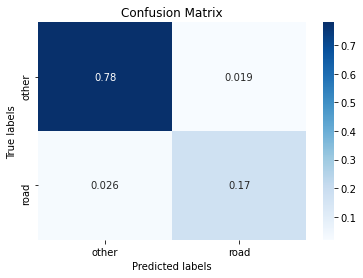

In [48]:
cm = confusion_matrix(valid_lab, valid_predictions, normalize='all')
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap=plt.cm.Blues); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['other', 'road']); ax.yaxis.set_ticklabels(['other', 'road']);

In [35]:
print("F1 score: ", f1_score(valid_lab, valid_predictions, average='weighted'))

F1 score:  0.953942148838456


In [10]:
test_img = np.array(Image.open('test_set_images/test_5/test_5.png')).astype('float32') / 255
inference = predict(model, test_img, PREDICT_BATCH_SIZE, IMG_WINDOW_SIZE, LAB_WINDOW_SIZE)

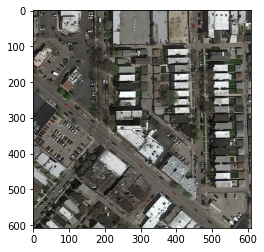

In [41]:
plt.imshow(test_img)

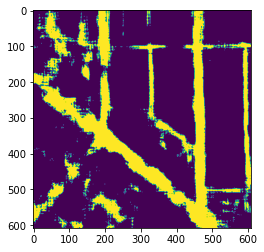

In [11]:
plt.imshow(inference)

In [13]:
def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg
model.eval()
for img_idx in [23,5,2,1]:
    test_img = np.array(Image.open(f'test_set_images/test_{img_idx}/test_{img_idx}.png')).astype('float32') / 255
    out = predict(model, test_img, PREDICT_BATCH_SIZE, IMG_WINDOW_SIZE, LAB_WINDOW_SIZE)
    Image.fromarray(img_float_to_uint8(out)).save(f'{img_idx}_basic_conv.png')

In [46]:
def to_submission(model_output,image_id):
    csv_arr = []
    for i in range(0,model_output.shape[0],16):
        for j in range(0,model_output.shape[1],16):
            prediction = 0
            patch = model_output[j:j+16, i:i+16]
            if np.mean(patch) > 0.25:
                prediction = 1
            csv_arr.append(["{:03d}_{}_{}".format(image_id,i,j),prediction])
    return csv_arr

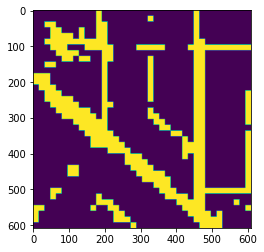

In [36]:
imageddd = np.zeros(inference.shape)
for i in range(0,inference.shape[0],16):
        for j in range(0,inference.shape[1],16):
            imageddd[i:i+16, j:j+16] = 0
            patch = inference[i:i+16, j:j+16]
            if np.mean(patch[:,:,0]<patch[:,:,1]) > 0.25:
                imageddd[i:i+16, j:j+16] = 1
plt.imshow(imageddd)

In [ ]:
outputs = []
for i in tqdm(range(50)):
    test_img = np.array(Image.open("test_set_images/test_"+str(i+1) +'/test_' + str(i+1)+'.png')).astype('float32') / 255
    output = predict(model, test_img, PREDICT_BATCH_SIZE, IMG_WINDOW_SIZE, LAB_WINDOW_SIZE)
    sub_output = to_submission(output,i+1)
    outputs.append(sub_output)

In [47]:
outputs_np = np.concatenate(outputs,axis=0)
outputs_np = np.concatenate(([['id','prediction']],outputs_np), axis=0)
np.savetxt("submit.csv", outputs_np, delimiter=",", fmt = '%s')

In [ ]:
valid_img, valid_lab

In [34]:
valid_lab.shape

(20000,)

In [23]:
valid_img.shape

(20000, 64, 64, 3)

In [ ]:
valid_img.shape

In [33]:
predictions_v = []
for imaj in tqdm(valid_img):
    model.eval()
    test_img_n = np.expand_dims(imaj,0)
    test_img_n = torch.from_numpy(np.transpose(test_img_n,(0,3,1,2))).float()
    out = model(test_img_n.cuda()).detach().cpu().numpy()
    prediction = 1
    if out[0][0]>out[0][1]:
        prediction = 0
    predictions_v.append(prediction)
predictions_v = np.array(predictions_v)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:34<00:00, 583.85it/s]


In [35]:
predictions_v.shape

(20000,)

In [39]:
Z_test = predictions_v
Y_test = valid_lab

precision,f1,recall,accuracy = precision_score(Y_test, Z_test),f1_score(Y_test, Z_test),recall_score(Y_test, Z_test),accuracy_score(Y_test, Z_test)

In [40]:
print(f'precision: {precision}, f1_score: {f1}, recall:{recall}, accuracy:{accuracy} ')

precision: 0.9161436103439619, f1_score: 0.9119080344870673, recall:0.9077114427860696, accuracy:0.96475 
